In [1]:
import os
import sys
import re
import json                                       
import gnssrefl.gps as g
import gnssrefl.rinex2snr as rnx
import gnssrefl.quickLook_function as quick
import gnssrefl.gnssir as guts
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns; sns.set_theme(style="whitegrid");

from datetime import datetime

# We are including our bin to the system path so that we can impor the following python modules
bin_path = os.path.abspath(os.path.join('../bin'))
if bin_path not in sys.path:
    sys.path.append(bin_path)
    
import check_parameters 
import environment

%matplotlib inline

In [2]:
#Making sure environment variables are set
exists = environment.check_environment()
if exists == False:
    environment.set_environment()
else:
     print('environment variable ORBITS path is', os.environ['ORBITS'],
          '\nenvironment variable REFL_CODE path is', os.environ['REFL_CODE'],
          '\nenvironment variable EXE path is', os.environ['EXE'])
        
# import the crx2rnx file
environment.download_crx2rnx()

environment variable ORBITS set to path /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/orbits 
environment variable REFL_CODE set to path /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter 
environment variable EXE set to path /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/bin/exe
downloading file
file placed in path to execubles set by EXE environment variable
cleaning up
finished


### Dye2, Greenland 

**Station Name:** gls1

**Location:**  Dye2, Qeqqata Province, Greenland 

**Archive:**  [UNAVCO](http://www.unavco.org), [SOPAC](http://sopac-csrc.ucsd.edu/index.php/sopac/)

**DOI:**  [https://doi.org/10.7283/T5WS8RDB](https://doi.org/10.7283/T5WS8RDB)

**Ellipsoidal Coordinates:**

- Latitude: 66.47940

- Longitude:  -46.31015

- Height: 2150 m

[Station Page at UNAVCO](https://www.unavco.org/instrumentation/networks/status/nota/overview/gls1)

[Station Page at Nevada Geodetic Laboratory](http://geodesy.unr.edu/NGLStationPages/stations/GLS1.sta)

[Google Maps Link](https://goo.gl/maps/391a7h2HpacAa59u8) 

<img src="../data/gls1-photo.png" width="400">
<img src="../data/gls1.jpg" width="400">
<BR>


## Data Summary

Station gls1 was installed at [Dye2](http://greenlandtoday.com/dye-2-a-relic-from-a-not-so-distant-past/?lang=en) on the Greenland Ice Sheet in 2011. 
The antenna is mounted on a long pole; approximately 3.5-meter of the pole was above the ice at the time of installation. 
The receiver at the site only consistently tracks legacy GPS signals. A detailed discussion of the monument and 
data from the station can be found in [Larson, MacFerrin, and Nylen (2020)](https://tc.copernicus.org/articles/14/1985/2020/tc-14-1985-2020.pdf). 
The latest position time series for gls1 can be retrieved 
from the [Nevada Geodetic Laboratory](http://geodesy.unr.edu/gps_timeseries/tenv3/IGS14/GLS1.tenv3). 
We also have a utility you can use: **download_unr**

As gls1 is on an ice sheet and the ice surface is relatively smooth in all directions, it 
is unlikely that a complicated azimuth mask will be required.
gls1 was originally installed with an elevation mask of 7 degrees, which is suboptimal for reflections research.
Even though the mask was later removed, we will use 7 degrees as the minimum elevation angle for all our analysis.
Similarly, even though the site managers later changed to enable L2C tracking, to ensure that 
a consistent dataset is being used, we will only use L1 data. gls1 is an example case 
for the GNSS-IR Web App:

In [3]:
%%html
<iframe src="https://gnss-reflections.org/api?example=gls1" width="800" height="950"></iframe>

## quickLook 

Our ultimate goal in this use case is to analyze one year of data. We have chosen the year 
2012 because there was a large melt event on the ice sheet. In order to set the proper
quality control parameters, we will use **quickLook** for one day. First we need to translate 
one day of RINEX data using **rinex2snr**. We will use day of year 100:

In [4]:
station = 'gls1'
year = 2012 
doy = 100

lat = 66.4794
long = -46.3102
height = 2148.578

In [5]:
# To understand what rinex2snr returns, you can uncomment the next line of code to learn more about this function 
# and it's default parameters
# check_parameters.rinex2snr?
args = check_parameters.rinex2snr(station, year, doy, translator='hybrid')
rnx.run_rinex2snr(**args)

SNR file exists /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls11000.12.snr66


minimum elevation angle (degrees) for this dataset:  6.8543
It looks like the receiver had an elevation mask


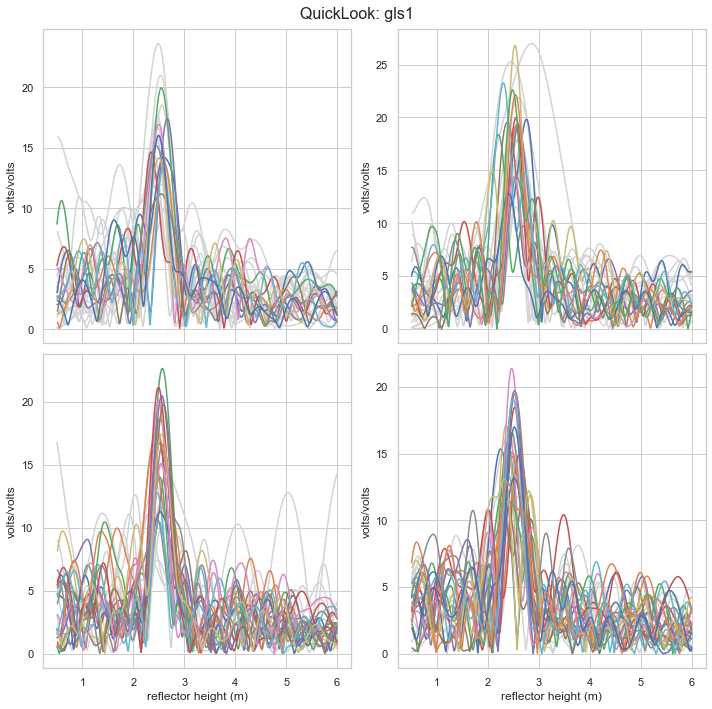

In [11]:
args = check_parameters.quicklook(station, year, doy=doy)
values, metrics = quick.quickLook_function(**args)
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10,10), sharex=True)
fig.suptitle(f'QuickLook: {args["station"]}', size=16)

quadrants = ['NW', 'NE', 'SW', 'SE']

for i, ax in enumerate(axes.flat):
    for fail_satellite in values[f'f{quadrants[i]}']:
        g = sns.lineplot(x=values[f'f{quadrants[i]}'][fail_satellite][0], y=values[f'f{quadrants[i]}'][fail_satellite][1], ax=ax, color='lightgrey')
    for satellite in values[quadrants[i]]:
        g = sns.lineplot(x=values[quadrants[i]][satellite][0], y=values[quadrants[i]][satellite][1], ax=ax)
    g.set_ylabel('volts/volts')
    g.set_xlabel('reflector height (m)')

plt.tight_layout()
plt.show()

This is a geographically oriented-summary of the frequency content of the GPS data.
The peaks in these periodograms tell us how high the GPS antenna is above the ice surface.
The peaks are associated with a reflector height (RH) of ~2.5 meters. [For more details on quicklook output](https://github.com/kristinemlarson/gnssrefl/blob/master/docs/quickLook_desc.md).

The next plot shows results with respect to azimuth angle.  The top plot is RH and the other 
two are quality control measures: peak amplitude and peak to noise ratio.


Average reflector height value: 2.5
QC value for peak to noise: 3
QC value for amplitude: 10


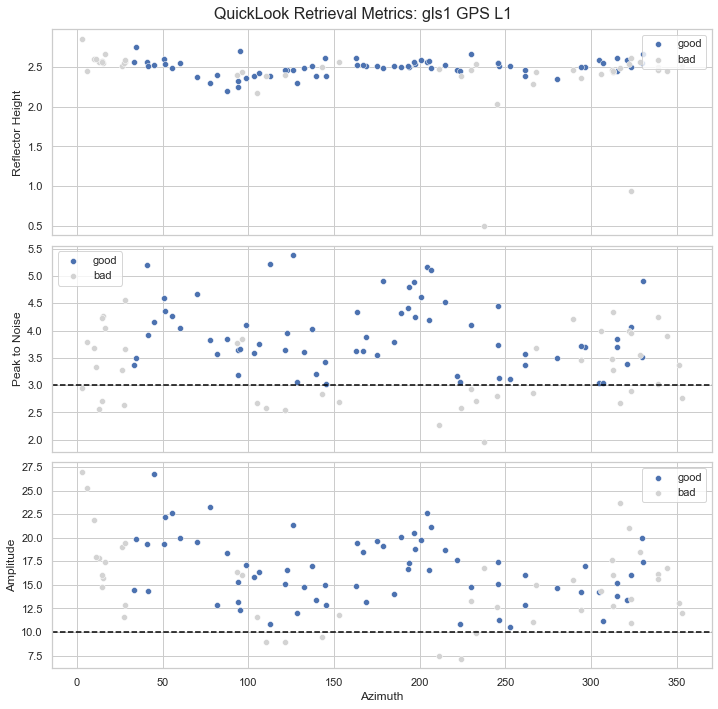

In [12]:
success, fail = check_parameters.quicklook_metrics(metrics)
fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(10,10), sharex=True)
fig.suptitle(f'QuickLook Retrieval Metrics: {args["station"]} GPS L1', size=16)

for i, ax in enumerate(axes):
    g = sns.scatterplot(x='Azimuth (deg)',y=success.columns[i+1], data=success, ax=ax, label='good')
    g = sns.scatterplot(x='Azimuth (deg)',y=fail.columns[i+1], data=fail, ax=ax, color='lightgrey', label='bad')
    
axes[0].legend(loc='upper right')

avg_rh = np.mean(success['Reflector Height'])
qc_val_peak2noise = round(min(success['Peak to Noise']))
axes[1].axhline(qc_val_peak2noise, linestyle='--', color='black', label='QC value used')
qc_val_amp = round(min(success['Amplitude']))
axes[2].axhline(qc_val_amp, linestyle='--', color='black', label='QC value used')
print(f'Average reflector height value: {avg_rh:.1f}')
print('QC value for peak to noise:', qc_val_peak2noise)
print('QC value for amplitude:', qc_val_amp)

plt.tight_layout()
plt.show()

In the top plot we see that the retrieved reflector heights are consistent at all azimuths.
Retrievals for azimuths between 340 degrees and 40 degrees are consistently marked as not having
met quality control settings.From the center plot we can see that a peak2noise QC metric of 3 is reasonable. 
Similarly, the amplitudes (bottom plot) are generally larger than 10, so 8 is an acceptable minimum value.

Compare that to its level when the site was installed in the year 2011:

Will seek RINEX file  gls1  year: 2011  doy: 271  translate with  hybrid
-1 / unknown........................................................................] 74535 / 74535

SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2011/snr/gls1/gls12710.11.snr66
minimum elevation angle (degrees) for this dataset:  6.9639
It looks like the receiver had an elevation mask


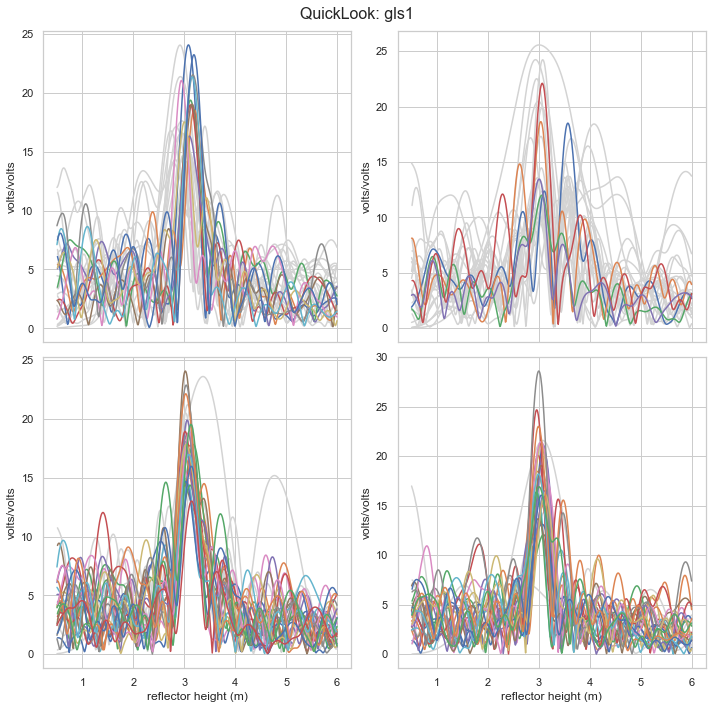

In [17]:
args = check_parameters.rinex2snr(station, year=2011, doy=271, archive='unavco', translator='hybrid')
rnx.run_rinex2snr(**args)

args = check_parameters.quicklook(station, 2011, doy=271)
values, datakeys = quick.quickLook_function(**args)
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10,10), sharex=True)
fig.suptitle(f'QuickLook: {args["station"]}', size=16)

for i, ax in enumerate(axes.flat):
    for fail_satellite in values[f'f{quadrants[i]}']:
        g = sns.lineplot(x=values[f'f{quadrants[i]}'][fail_satellite][0], y=values[f'f{quadrants[i]}'][fail_satellite][1], ax=ax, color='lightgrey')
    for satellite in values[quadrants[i]]:
        g = sns.lineplot(x=values[quadrants[i]][satellite][0], y=values[quadrants[i]][satellite][1], ax=ax)
    g.set_ylabel('volts/volts')
    g.set_xlabel('reflector height (m)')

plt.tight_layout()
plt.show()

The first step is to make SNR files for the year 2012:

In [13]:
args = check_parameters.rinex2snr(station,year,1, doy_end=366, translator='hybrid')
rnx.run_rinex2snr(**args)

Will seek RINEX file  gls1  year: 2012  doy: 1  translate with  hybrid
-1 / unknown........................................................................] 71055 / 71055

SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls10010.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 2  translate with  hybrid
-1 / unknown........................................................................] 72741 / 72741

SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls10020.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 3  translate with  hybrid
-1 / unknown........................................................................] 73141 / 73141

SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls10030.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 4  translate with  hybrid
-1 / unknown..............................................................

-1 / unknown........................................................................] 72261 / 72261

SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls10300.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 31  translate with  hybrid
-1 / unknown........................................................................] 71769 / 71769

SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls10310.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 32  translate with  hybrid
-1 / unknown........................................................................] 72611 / 72611

SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls10320.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 33  translate with  hybrid
-1 / unknown........................................................................] 75323 / 75323

SUCCESS: SNR file was created: /Users/enl

-1 / unknown........................................................................] 74763 / 74763

SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls10590.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 60  translate with  hybrid
-1 / unknown........................................................................] 75549 / 75549

SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls10600.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 61  translate with  hybrid
-1 / unknown........................................................................] 76317 / 76317

SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls10610.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 62  translate with  hybrid
-1 / unknown........................................................................] 74029 / 74029

SUCCESS: SNR file was created: /Users/enl

-1 / unknown........................................................................] 74665 / 74665

SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls10880.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 89  translate with  hybrid
-1 / unknown........................................................................] 75207 / 75207

SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls10890.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 90  translate with  hybrid
-1 / unknown........................................................................] 74609 / 74609

SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls10900.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 91  translate with  hybrid
-1 / unknown........................................................................] 74429 / 74429

SUCCESS: SNR file was created: /Users/enl

-1 / unknown........................................................................] 74043 / 74043

SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls11170.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 118  translate with  hybrid
-1 / unknown........................................................................] 75051 / 75051

SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls11180.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 119  translate with  hybrid
-1 / unknown........................................................................] 74799 / 74799

SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls11190.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 120  translate with  hybrid
-1 / unknown........................................................................] 73889 / 73889

SUCCESS: SNR file was created: /Users/

-1 / unknown........................................................................] 75011 / 75011

SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls11460.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 147  translate with  hybrid
-1 / unknown........................................................................] 73873 / 73873

SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls11470.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 148  translate with  hybrid
-1 / unknown........................................................................] 73629 / 73629

SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls11480.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 149  translate with  hybrid
-1 / unknown........................................................................] 74973 / 74973

SUCCESS: SNR file was created: /Users/

-1 / unknown........................................................................] 73107 / 73107

SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls11750.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 176  translate with  hybrid
-1 / unknown........................................................................] 71509 / 71509

SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls11760.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 177  translate with  hybrid
-1 / unknown........................................................................] 72915 / 72915

SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls11770.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 178  translate with  hybrid
-1 / unknown........................................................................] 73299 / 73299

SUCCESS: SNR file was created: /Users/

--2021-08-18 16:59:46--  ftps://gdc.cddis.eosdis.nasa.gov/gps/data/daily/2012/199/12n/brdc1990.12n.Z
           => ‘brdc1990.12n.Z’
Resolving gdc.cddis.eosdis.nasa.gov (gdc.cddis.eosdis.nasa.gov)... 198.118.242.43
Connecting to gdc.cddis.eosdis.nasa.gov (gdc.cddis.eosdis.nasa.gov)|198.118.242.43|:21... connected.
==> AUTH TLS ...  done.
Logging in as anonymous ... Logged in!
==> PBSZ 0 ... done.  ==> PROT P ... done.
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /gps/data/daily/2012/199/12n ... done.
==> SIZE brdc1990.12n.Z ... 66301
==> PASV ... done.    ==> RETR brdc1990.12n.Z ... done.
Length: 66301 (65K) (unauthoritative)
Resuming SSL session in data connection.

     0K .......... .......... .......... .......... .......... 77%  475K 0s
    50K .......... ....                                       100% 46.8M=0.1s

2021-08-18 16:59:48 (614 KB/s) - ‘brdc1990.12n.Z’ saved [66301]



found it and move to ORBIT area
-1 / unknown

SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls11990.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 200  translate with  hybrid
-1 / unknown........................................................................] 72719 / 72719

SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls12000.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 201  translate with  hybrid
-1 / unknown........................................................................] 73561 / 73561

SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls12010.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 202  translate with  hybrid
-1 / unknown........................................................................] 73221 / 73221

SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls

--2021-08-18 17:01:02--  ftps://gdc.cddis.eosdis.nasa.gov/gps/data/daily/2012/210/12n/brdc2100.12n.Z
           => ‘brdc2100.12n.Z’
Resolving gdc.cddis.eosdis.nasa.gov (gdc.cddis.eosdis.nasa.gov)... 198.118.242.43
Connecting to gdc.cddis.eosdis.nasa.gov (gdc.cddis.eosdis.nasa.gov)|198.118.242.43|:21... connected.
==> AUTH TLS ...  done.
Logging in as anonymous ... Logged in!
==> PBSZ 0 ... done.  ==> PROT P ... done.
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /gps/data/daily/2012/210/12n ... done.
==> SIZE brdc2100.12n.Z ... 65655
==> PASV ... done.    ==> RETR brdc2100.12n.Z ... done.
Length: 65655 (64K) (unauthoritative)
Resuming SSL session in data connection.

     0K .......... .......... .......... .......... .......... 77%  532K 0s
    50K .......... ....                                       100% 56.7M=0.09s

2021-08-18 17:01:03 (680 KB/s) - ‘brdc2100.12n.Z’ saved [65655]



found it and move to ORBIT area
-1 / unknown

SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls12100.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 211  translate with  hybrid


--2021-08-18 17:01:06--  ftps://gdc.cddis.eosdis.nasa.gov/gps/data/daily/2012/211/12n/brdc2110.12n.Z
           => ‘brdc2110.12n.Z’
Resolving gdc.cddis.eosdis.nasa.gov (gdc.cddis.eosdis.nasa.gov)... 198.118.242.43
Connecting to gdc.cddis.eosdis.nasa.gov (gdc.cddis.eosdis.nasa.gov)|198.118.242.43|:21... connected.
==> AUTH TLS ...  done.
Logging in as anonymous ... Logged in!
==> PBSZ 0 ... done.  ==> PROT P ... done.
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /gps/data/daily/2012/211/12n ... done.
==> SIZE brdc2110.12n.Z ... 65851
==> PASV ... done.    ==> RETR brdc2110.12n.Z ... done.
Length: 65851 (64K) (unauthoritative)
Resuming SSL session in data connection.

     0K .......... .......... .......... .......... .......... 77%  438K 0s
    50K .......... ....                                       100% 85.7M=0.1s

2021-08-18 17:01:07 (562 KB/s) - ‘brdc2110.12n.Z’ saved [65851]



found it and move to ORBIT area
-1 / unknown

SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls12110.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 212  translate with  hybrid


--2021-08-18 17:01:10--  ftps://gdc.cddis.eosdis.nasa.gov/gps/data/daily/2012/212/12n/brdc2120.12n.Z
           => ‘brdc2120.12n.Z’
Resolving gdc.cddis.eosdis.nasa.gov (gdc.cddis.eosdis.nasa.gov)... 198.118.242.43
Connecting to gdc.cddis.eosdis.nasa.gov (gdc.cddis.eosdis.nasa.gov)|198.118.242.43|:21... connected.
==> AUTH TLS ...  done.
Logging in as anonymous ... Logged in!
==> PBSZ 0 ... done.  ==> PROT P ... done.
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /gps/data/daily/2012/212/12n ... done.
==> SIZE brdc2120.12n.Z ... 65941
==> PASV ... done.    ==> RETR brdc2120.12n.Z ... done.
Length: 65941 (64K) (unauthoritative)
Resuming SSL session in data connection.

     0K .......... .......... .......... .......... .......... 77%  469K 0s
    50K .......... ....                                       100% 83.2M=0.1s

2021-08-18 17:01:11 (603 KB/s) - ‘brdc2120.12n.Z’ saved [65941]



found it and move to ORBIT area
-1 / unknown

SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls12120.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 213  translate with  hybrid
-1 / unknown........................................................................] 73433 / 73433

SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls12130.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 214  translate with  hybrid
-1 / unknown........................................................................] 73059 / 73059

SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls12140.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 215  translate with  hybrid
-1 / unknown........................................................................] 73439 / 73439

SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls

-1 / unknown........................................................................] 73569 / 73569

SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls12410.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 242  translate with  hybrid
-1 / unknown........................................................................] 73905 / 73905

SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls12420.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 243  translate with  hybrid
-1 / unknown........................................................................] 73929 / 73929

SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls12430.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 244  translate with  hybrid
-1 / unknown........................................................................] 73605 / 73605

SUCCESS: SNR file was created: /Users/

-1 / unknown........................................................................] 73133 / 73133

SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls12700.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 271  translate with  hybrid
-1 / unknown........................................................................] 72595 / 72595

SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls12710.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 272  translate with  hybrid
-1 / unknown........................................................................] 73033 / 73033

SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls12720.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 273  translate with  hybrid
-1 / unknown........................................................................] 73351 / 73351

SUCCESS: SNR file was created: /Users/

-1 / unknown........................................................................] 74523 / 74523

SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls12990.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 300  translate with  hybrid
-1 / unknown........................................................................] 74911 / 74911

SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls13000.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 301  translate with  hybrid
-1 / unknown........................................................................] 75015 / 75015

SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls13010.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 302  translate with  hybrid
-1 / unknown........................................................................] 74595 / 74595

SUCCESS: SNR file was created: /Users/

-1 / unknown........................................................................] 75155 / 75155

SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls13280.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 329  translate with  hybrid
-1 / unknown........................................................................] 74541 / 74541

SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls13290.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 330  translate with  hybrid
-1 / unknown........................................................................] 74953 / 74953

SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls13300.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 331  translate with  hybrid
-1 / unknown........................................................................] 76225 / 76225

SUCCESS: SNR file was created: /Users/

--2021-08-18 17:11:01--  ftps://gdc.cddis.eosdis.nasa.gov/gps/data/daily/2012/344/12n/brdc3440.12n.Z
           => ‘brdc3440.12n.Z’
Resolving gdc.cddis.eosdis.nasa.gov (gdc.cddis.eosdis.nasa.gov)... 198.118.242.43
Connecting to gdc.cddis.eosdis.nasa.gov (gdc.cddis.eosdis.nasa.gov)|198.118.242.43|:21... connected.
==> AUTH TLS ...  done.
Logging in as anonymous ... Logged in!
==> PBSZ 0 ... done.  ==> PROT P ... done.
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /gps/data/daily/2012/344/12n ... done.
==> SIZE brdc3440.12n.Z ... 68151
==> PASV ... done.    ==> RETR brdc3440.12n.Z ... done.
Length: 68151 (67K) (unauthoritative)
Resuming SSL session in data connection.

     0K .......... .......... .......... .......... .......... 75%  441K 0s
    50K .......... ......                                     100% 4.04M=0.1s

2021-08-18 17:11:02 (566 KB/s) - ‘brdc3440.12n.Z’ saved [68151]



found it and move to ORBIT area
-1 / unknown

SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls13440.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 345  translate with  hybrid


--2021-08-18 17:11:05--  ftps://gdc.cddis.eosdis.nasa.gov/gps/data/daily/2012/345/12n/brdc3450.12n.Z
           => ‘brdc3450.12n.Z’
Resolving gdc.cddis.eosdis.nasa.gov (gdc.cddis.eosdis.nasa.gov)... 198.118.242.43
Connecting to gdc.cddis.eosdis.nasa.gov (gdc.cddis.eosdis.nasa.gov)|198.118.242.43|:21... connected.
==> AUTH TLS ...  done.
Logging in as anonymous ... Logged in!
==> PBSZ 0 ... done.  ==> PROT P ... done.
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /gps/data/daily/2012/345/12n ... done.
==> SIZE brdc3450.12n.Z ... 71061
==> PASV ... done.    ==> RETR brdc3450.12n.Z ... done.
Length: 71061 (69K) (unauthoritative)
Resuming SSL session in data connection.

     0K .......... .......... .......... .......... .......... 72%  442K 0s
    50K .......... .........                                  100%  103M=0.1s

2021-08-18 17:11:06 (612 KB/s) - ‘brdc3450.12n.Z’ saved [71061]



found it and move to ORBIT area
-1 / unknown

SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls13450.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 346  translate with  hybrid


--2021-08-18 17:11:09--  ftps://gdc.cddis.eosdis.nasa.gov/gps/data/daily/2012/346/12n/brdc3460.12n.Z
           => ‘brdc3460.12n.Z’
Resolving gdc.cddis.eosdis.nasa.gov (gdc.cddis.eosdis.nasa.gov)... 198.118.242.43
Connecting to gdc.cddis.eosdis.nasa.gov (gdc.cddis.eosdis.nasa.gov)|198.118.242.43|:21... connected.
==> AUTH TLS ...  done.
Logging in as anonymous ... Logged in!
==> PBSZ 0 ... done.  ==> PROT P ... done.
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /gps/data/daily/2012/346/12n ... done.
==> SIZE brdc3460.12n.Z ... 66769
==> PASV ... done.    ==> RETR brdc3460.12n.Z ... done.
Length: 66769 (65K) (unauthoritative)
Resuming SSL session in data connection.

     0K .......... .......... .......... .......... .......... 76%  421K 0s
    50K .......... .....                                      100% 77.7M=0.1s

2021-08-18 17:11:10 (548 KB/s) - ‘brdc3460.12n.Z’ saved [66769]



found it and move to ORBIT area
-1 / unknown

SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls13460.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 347  translate with  hybrid
-1 / unknown........................................................................] 75195 / 75195

SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls13470.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 348  translate with  hybrid
-1 / unknown........................................................................] 75571 / 75571

SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls13480.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 349  translate with  hybrid
-1 / unknown........................................................................] 75345 / 75345

SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls

We will next analyze a year of L1 GPS reflection data from this site. We will use the default minimum and maximum 
reflector height values (0.4 and 6 meters). But for the reasons previously stated, we will set a minimum elevation angle 
of 7 degrees. We also specify that we only want to use the L1 data and set peak2noise and a mimimum
amplitude for the periodograms. We use the utility **make_json_input** to set and store these analysis settings:

In [18]:
check_parameters.make_json(station, lat, long, height, e1=7, peak2noise=3, ampl=8, l1=True)

writing out to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/input/gls1.json


In [19]:
# This is the json file that was created
json_file = '../input/gls1.json'
with open(json_file, "r") as myfile:
    file = json.load(myfile)
    file['azval'] = [40,90,90,180,180,270,270,330]
os.remove(json_file)
with open(json_file, 'w') as f:
    json.dump(file, f, indent=4)
    
with open(json_file, "r") as myfile:
    file = json.load(myfile)

file

{'station': 'gls1',
 'lat': 66.4794,
 'lon': -46.3102,
 'ht': 2148.578,
 'minH': 0.5,
 'maxH': 6,
 'e1': 7,
 'e2': 25,
 'NReg': [0.5, 6],
 'PkNoise': 3,
 'polyV': 4,
 'pele': [5, 30],
 'ediff': 2,
 'desiredP': 0.005,
 'azval': [40, 90, 90, 180, 180, 270, 270, 330],
 'freqs': [1],
 'reqAmp': [8],
 'refraction': True,
 'overwriteResults': True,
 'seekRinex': False,
 'wantCompression': False,
 'plt_screen': False,
 'onesat': None,
 'screenstats': True,
 'pltname': 'gls1_lsp.png',
 'delTmax': 75}

We have also excluded a bit of the northern tracks by hand-editing the json. This is not required as 
the software appears to be appropriately removing these unreliable azimuths. Note: the removal of these
azimuths is more related to the GPS satellite inclination than local conditions at gls1.

Now that you have SNR files and json inputs, you can go ahead and estimate reflector heights for the year 2012:

In [20]:
year = 2012
doy = 1
doy_end = 366
plt=False
args = check_parameters.gnssir(station, year, doy, doy_end=doy_end, plt=plt, screenstats=False)
year_list = list(range(year, args['year_end'] + 1))
doy_list = list(range(doy, args['doy_end'] + 1))
for year in year_list:
    args['args']['year'] = year
    for doy in doy_list:
        args['args']['doy'] = doy
        guts.gnssir_guts(**args['args'])

download and move refraction file
100% [........................................................................] 21773344 / 21773344A station specific refraction output file will be written to  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/input/gls1_refr.txt
The large refraction file should be stored here: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/input/gpt_1wA.pickle
station specific refraction file written
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//001.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls10010.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//002.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls10020.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//003.txt
reading from this snr file  /Users/enloe/UNAVCO_Pro

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//038.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls10380.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//039.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls10390.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//040.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls10400.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//041.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls10410.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//042.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//077.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls10770.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//078.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls10780.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//079.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls10790.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//080.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls10800.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//081.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//116.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls11160.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//117.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls11170.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//118.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls11180.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//119.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls11190.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//120.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//155.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls11550.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//156.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls11560.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//157.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls11570.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//158.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls11580.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//159.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//194.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls11940.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//195.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls11950.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//196.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls11960.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//197.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls11970.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//198.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//233.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls12330.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//234.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls12340.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//235.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls12350.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//236.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls12360.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//237.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//272.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls12720.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//273.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls12730.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//274.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls12740.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//275.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls12750.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//276.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//311.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls13110.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//312.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls13120.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//313.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls13130.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//314.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls13140.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//315.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//350.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls13500.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//351.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls13510.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//352.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls13520.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//353.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls13530.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//354.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

We will use the **daily_avg** tool to compute a daily average RH. A median filter is set to 0.25 meters 
and 30 individual tracks are required in order to recover a daily average:

In [21]:
check_parameters.daily_avg(station, medfilter=.25, ReqTracks=30, plt2screen=False, txtfile='gls1-dailyavg.txt')

make an output directory /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/Files
all RH will be written to:  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/Files/gls1_allRH.txt
Number of files in  2012 366
not enough retrievals on  2012 6 9 20
Daily average RH png file saved as:  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/Files/gls1_RH.png
Daily average RH will be written to:  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/Files/gls1-dailyavg.txt


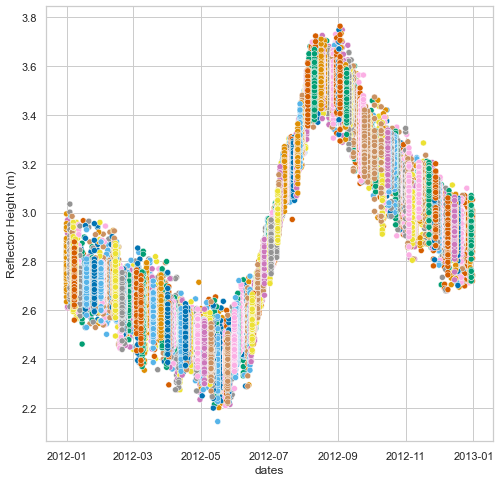

In [24]:
refl_code_directory = os.environ['REFL_CODE']
import matplotlib.pyplot as plt
def read_allRH_file(filepath, regex):
    data = {'dates': [], 'rh': []}
    #read daily average reflector heights
    with open(f'{refl_code_directory}{filepath}', 'r') as myfile:
        file = myfile.read()
        matches = re.finditer(regex, file, flags=re.MULTILINE)

        for match in matches:
            ydoy = f'{int(match.group("year"))}-{int(match.group("doy"))}'
            date = datetime.strptime(ydoy, '%Y-%j').date()
            data['dates'].append(date)
            data['rh'].append(float(match.group('rh')))
            
    return data

regex = '^ (?P<year>[ \d]+) +(?P<doy>[\d]+) +(?P<rh>[\d|-|.]+)'
filepath = f'/Files/{station}_allRH.txt'
data = read_allRH_file(filepath, regex)

df = pd.DataFrame(data, index=None, columns=['dates', 'rh'])
plt.figure(figsize=(8,8))
g = sns.scatterplot(x='dates', y='rh', data=df, hue='dates', palette='colorblind', legend=False)
g.set_ylabel('Reflector Height (m)');

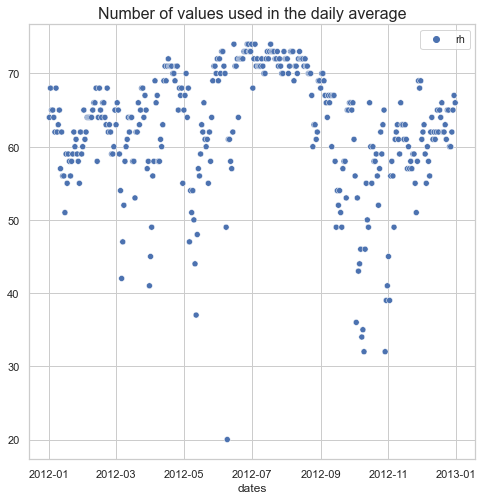

In [25]:
plt.figure(figsize=(8,8))
df_group = df.groupby(['dates']).agg(['count'])
g = sns.scatterplot(data=df_group)
g.set_title('Number of values used in the daily average', size=16);

In [26]:
regex = '^ (?P<year>[ \d]+) +(?P<doy>[\d]+) +(?P<rh>[\d|-|.]+)'
filepath = f'/Files/{station}-dailyavg.txt'
data = read_allRH_file(filepath, regex)
df = pd.DataFrame(data, index=None, columns=['dates', 'rh'])

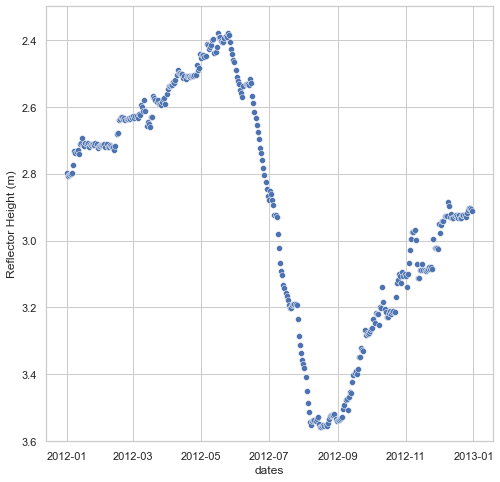

In [27]:
plt.figure(figsize=(8,8))
g = sns.scatterplot(x='dates', y='rh', data=df, legend=False)
g.set_ylim(3.6,2.3)
g.set_ylabel('Reflector Height (m)');

Three plots are returned. The first is all tracks. The second shows the number of tracks used in the daily average.Finally, the average RH each day for the year 2012.

This data shown in the last plot show you long-term accumulation as well as relatively small snow accumulation events. The overall 
plot is dominated by the large melt event in the summer.

**Things to think about:**

* Why do the number of useable tracks drop drastically at various times in the year?

* Why are the number of tracks retrieved in the summer days consistently higher in number than 
in other times of the year? What is different about the surface in the summer of 2012?

* How would you find out whether this year was anomalously large melt?  

* Try comparing the GNSS-IR results with the [validation data](https://tc.copernicus.org/articles/14/1985/2020/tc-14-1985-2020.pdf)

The original [J. Glaciology paper](https://www.kristinelarson.net/wp-content/uploads/2015/10/LarsonWahrKuipers_2015.pdf ) discussing this site.